**<center><font size = 7> Garbage Classifier using Xception, DenseNet121, InceptionV3,InceptionResNetV2, VGG16 and VGG19 </font></center>**
 




In [2]:
# Gerekli kütüphaneleri tanımlıyoruz
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow  

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Veri artırımı (Data Augmentation) yaparak görüntüleri farklı varyasyonlarla çoğaltır
from tensorflow.keras.applications import Xception  # Kullanılacak yapay sinir ağı modeli
from tensorflow.keras.layers import Flatten, Dense, Dropout  # Yapay sinir ağı katmanlarının yapı taşları
from tensorflow.keras.models import Sequential  # Katmanları sıralı bir şekilde eklemek için kullanılan model oluşturucu
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam  # Optimizasyon algoritmaları
from tensorflow.keras.regularizers import l1, l2, L1L2  # Yapay sinir ağlarında düzenleme terimleri
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Eğitim sürecini kontrol etmek ve modelin durumunu kaydetmek için kullanacağız

from glob import glob  # Dosya yollarını toplamak ve üzerinde işlem yapmak için kullanılır
import os  # İşletim sistemi ile ilgili işlemleri gerçekleştirmek için kullanılan kütüphane
import random  # Rastgele seçimler yapmak için kullanılan kütüphane
import shutil  # Dosya ve dizin işlemleri için kullanılan 

# Tekrar üretilebilirlik sağlamak için rastgelelik tohumları belirleniyor
tensorflow.random.set_seed(0)  # TensorFlow için rastgelelik tohumu 
np.random.seed(0)  # NumPy için rastgelelik tohumu 


# *Veri Ön İşleme Aşamaları*

In [4]:
path = "/kaggle/input/split-garbage-dataset/" # Veri kümemizin yolunu veriyoruz

In [ ]:
train_datagen = ImageDataGenerator( # Veri ön işleme adımları
    rescale = 1./255,  # Normalize
    rotation_range = 20,  # 20 derecelik açıyla döndürme işlemleri
    width_shift_range = 0.2, # Görüntünün %20 kadarlık kısmını yatayda kaydırır
    height_shift_range = 0.2, # Görüntünün %20 kadarlık kısmını dikeyde kaydırır
    horizontal_flip = True,  # Görüntünün yatayda rastgele bir şekilde ters çevrilmesini sağlar
    vertical_flip = True, # Görüntünün dikeyde rastgele bir şekilde ters çevrilmesini sağlar
    fill_mode = 'nearest') # Görüntüler kaydırıldığında oluşan boşluklar komşu piksel değerleriyle doldurulur
 
validation_datagen = ImageDataGenerator(rescale = 1./255) # Validation verileri normalize edilir
test_datagen = ImageDataGenerator(rescale = 1./255)  # Test verileri normalize edilir

In [ ]:
img_shape = (299, 299, 3)  # Giriş görüntüsünün genişlik, yükseklik ve renk kanalları(RGB) 

# Veri grupları için batch size değerleri
train_batch_size = 256  # Eğitim verileri için gruplama boyutu
validation_batch_size = 32  # Doğrulama verileri için gruplama boyutu

# Test veri setinin uzunluğunu hesaplıyoruz
len_test = glob('/kaggle/input/split-garbage-dataset/test/*/*')  # Test setindeki dosyaların listesi alınır
test_generator_length = len(len_test)  # Test setindeki toplam dosya sayısı

# Eğitim verisi oluşturucu
train_generator = train_datagen.flow_from_directory(
    path + 'train',  # Eğitim verisinin bulunduğu dizin
    target_size=(img_shape[0], img_shape[1]),  # Hedef boyut olarak img_shape kullanılıyor
    batch_size=train_batch_size,  # Eğitim için batch boyutu
    class_mode='categorical'  # Sınıflar arası dağılımı kategorik şekilde ayarlıyoruz
)

# Doğrulama verisi oluşturucu
validation_generator = validation_datagen.flow_from_directory(
    path + 'valid',  # Doğrulama verisinin bulunduğu dizin
    target_size=(img_shape[0], img_shape[1]),  # Hedef boyut olarak img_shape kullanılıyor
    batch_size=validation_batch_size,  # Doğrulama için batch boyutu
    class_mode='categorical',  # Sınıflar arası dağılımı kategorik şekilde ayarlıyoruz
    shuffle=False  # Verileri karıştırmıyoruz
)

# Test verisi oluşturucu
test_generator = test_datagen.flow_from_directory(
    path + 'test',  # Test verisinin bulunduğu dizin
    target_size=(img_shape[0], img_shape[1]),  # Hedef boyut olarak img_shape kullanılıyor
    batch_size=validation_batch_size,  # Test için batch boyutu
    class_mode='categorical',  # Sınıflar arası dağılımı kategorik şekilde ayarlıyoruz
    shuffle=False  # Verileri karıştırmıyoruz
)

# Test veri setinin tamamını bir seferde yüklemek için test_val oluşturucu
test_val = test_datagen.flow_from_directory(
    path + 'test',  # Test verisinin bulunduğu dizin
    target_size=(img_shape[0], img_shape[1]),  # Hedef boyut olarak img_shape kullanılıyor
    batch_size=len_test,  # Batch boyutunu test veri setinin toplam uzunluğu olarak ayarlıyoruz
    class_mode='categorical',  # Sınıflar arası dağılımı kategorik şekilde ayarlıyoruz
    shuffle=False  # Verileri karıştırmıyoruz
)


Verilerimizi model için hazır hale getirdik Xception Modelini oluşturmaya başlayabiliriz

# **Xception Modeli**

In [ ]:
xception = Xception(weights = 'imagenet', # ImageNet üzerinde eğitilmiş Xception adlı mimariyi alıyoruz
            include_top = False, # Son katman olan output katmanını almıyoruz biz kendi çıktı katmanımızı ekleyeceğiz
           input_shape = img_shape)  # Girdi boyutları
#input_shape=(224,224) olurdu normalde ama biz onu aşağıda belirteceğiz, burada sadece saf Xception'u çağırıyoruz

In [ ]:
print(xception.summary())   #  Xception'a ait olan katmanları görüyoruz

In [ ]:
for layer in xception.layers[:-3]:   #  Xception modeline ait olan son 3 katmanı eğitime dahil etmiyoruz 
    layer.trainable = False     #  son 3 katmanı biz ekleyeceğiz

In [ ]:
model = Sequential() #  Modelimizi çağırdık

model.add(xception) # Modele Xception'un son halini çağırdık
                    
# Xception'nın üzerine kendi katmanlarımızı ekliyoruz
model.add(Flatten()) # Vektörleri tek boyuta indirgiyoruz
model.add(Dense(1024, activation='relu')) #1024 nöron ekliyoruz
model.add(Dropout(0.2)) # overfitting'i önlemek için dropout uyguluyoruz 
model.add(Dense(6,activation='softmax')) #son olarak sınıflanıdırma katmanımızı ekliyoruz

In [ ]:
model.summary()  # modele ait olan katmanları ve bu katmanlar hakkındaki bilgileri veriyor

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma problemleri için kayıp fonksiyonu
    optimizer=RMSprop(learning_rate=1e-4),  # Optimize edici olarak RMSprop, learnin rate 0.0001
    metrics=['accuracy']  # Modelin doğruluğunu metrik olarak izlenecek
)


In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)  # Eğitim sırasında modelin performansını izlenir ve doğrulama kaybı 10 epoch boyunca iyileşmezse eğitim durdurulacaktır
mc = ModelCheckpoint('/kaggle/working/xception_weights.h5', monitor='val_acc',mode='max',verbose=1, save_best_only=True) # Koşul sağlandığında modelin ağırlıklarını kaydeder. Bu, en iyi modelin kaydedilmesini sağlar.
# False = Her Epoch'ta ağrlığı kaydeder

history = model.fit( #  Modelin eğitim süreci başlatılır. 
    train_generator, 
    steps_per_epoch = train_generator.samples/train_generator.batch_size,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size,
    verbose=1,  # Eğitim sırasında bilgi mesajlarını ekrana yazdırır (0 = False)
    callbacks = [es,mc])

model.save("/kaggle/working/xception_weights_all.h5")

In [ ]:
score = model.evaluate(validation_generator, batch_size=32) # Modelin doğrulama verisi üzerinde ne kadar iyi performans gösterdiğini değerlendiriyoruz  
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [ ]:
print(history.history.keys())

In [ ]:
# Accuracy ve loss değerlerini alıyoruz
train_acc = history.history['acc'] 
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure() # Farklı bir grafik üzerinde gösteriyoruz

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss') # Eğitim doğruluğunu mavi renkte ve yıldız işaretleriyle çizdiriyoruz
plt.plot(epochs, val_loss, 'r', label = 'Validation loss') # Eğitim doğruluğunu kırmızı renkte çizdiriyoruz
plt.title('Training and validation loss')
plt.legend()

plt.show()

* İki grafik arasında küçük bir fark olması normaldir
* İki ölçümde aynı yönde ilerliyorsa her şey yolunda demektir.
* Eğim metriği gelişmeye devam ederken doğrulama metriği durgunlaşmaya başlarsa aşırı uyuma yaklaşıyorsunuz demektir.
* Doğrulama ölçüsü yanlış yöne gidiyorsa, model açıkça gereğinden fazla uyumludur. 

In [ ]:
x_val, y_val = test_val.next() # ikili array dizileri arasında birbiri ardına veri çekmek için kullanılan bir fonksiyondur (next())

In [ ]:
x_test = np.asarray(x_val) # x_val değerlerini bir array'e çevirir
print(x_test.shape)

y_test = np.asarray(y_val) # y_valdeğerlerini bir array'a çevirir
print(y_test.shape)

y_true = y_test # doğru sınıf ve görüntü uyuşmalarını birbirine eşitler

pred_Y = model.predict(x_test, batch_size = 32, verbose=True) # x_test verilerini modele vererek genel bir doğruluk hesaplaması yaptırır
pred_Y_cat = np.argmax(pred_Y, -1) # elindeki doğruluklar olasılıksal bir dağılım yaptıkları için aralarından en büyüğünü seçilir
print(pred_Y_cat)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm=(confusion_matrix(np.argmax(y_true,-1), pred_Y_cat)) # confusion matrix oluşturulur
print(cm)

In [ ]:
cm2 = pd.DataFrame(cm,columns=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"],index=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"])
plt.figure(figsize=(6,5))

hm = sns.heatmap(cm2,annot=True,fmt ='n')
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel('Model tahmini')
hm.xaxis.set_label_position('top')
hm.set_ylabel('Gerçek Değerler')

# *Xception Modelinin Test Edilmesi*

In [ ]:
from sklearn.preprocessing import LabelBinarizer #  LabelBinarizer fonksiyonu labelları matrise çevirir.
LABELS=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"] # Etiket isimlerini belirliyoruz

labels = np.array(LABELS) # labellarımızı numpy array'i içine aldık
lb = LabelBinarizer()  # lb değişkenine LabelBinarizer() fonksiyonunu atadık
labels = lb.fit_transform(labels)  #  matrise çevirilen labelları kolonlara çevirir yani 1xn'lik matrislere

In [ ]:
# imutils kütüphanesi kaggle içinde bulunmadığı için biz indiriyoruz
!pip install imutils

In [ ]:
# test için gereken kütüphaneleri import ediyoruz
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [ ]:
print("[INFO] loading object detector...")
model = load_model('./xception_weights_all.h5')  # Eğittimiz modelin ağırlıklarını çağırdık
                                                 # Bu ağırlığı modele verdik ve model bu ağırlığa göre test yapıyoruz

In [ ]:
def predictImg(imagePath):  
    image = cv2.imread(imagePath)  # Görseli oku
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye çevir
    output = image.copy()  # Ana görselin kopyasını al
    image = cv2.resize(image, (299, 299))  # Xception için 299x299 boyutuna yeniden boyutlandır
    image = image.astype("float32") / 255.0  # Görseli normalize et (Xception için uygundur)
    image = img_to_array(image)  # Görseli diziye dönüştür
    image = np.expand_dims(image, axis=0)  # Görseli batch boyutunda genişlet

    # Modelin tahminini yap
    proba = model.predict(image)[0]  
    idx = np.argmax(proba)  # En yüksek doğruluk oranına sahip olan sınıfı bul
    label = lb.classes_[idx]  # Sınıfı al
    label = "{}: {:.2f}%".format(label, proba[idx] * 100)  # Etiketi formatla

    # Sonuçları görselleştir
    cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)  # Etiketi ekle
    fig = plt.figure(figsize=(10, 10))
    plt.grid(b=None)
    plt.axis('off')
    return plt.imshow(output)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/cardboard/cardboard121.jpg'
predictImg(imagePath)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/metal/metal246.jpg'
predictImg(imagePath)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/paper/paper124.jpg'
predictImg(imagePath)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/plastic/plastic2.jpg'
predictImg(imagePath)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Verilen predict fonksiyonu kullanılacak

def testRandom(test_dir, model, lb):  # Rastgele 5 farklı sınıftan 5 farklı resimi test etmek için function
    classes = os.listdir(test_dir)  # Klasördeki sınıf isimlerini al
    selected_classes = random.sample(classes, 5)  # 5 rastgele sınıf seç

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Görselleri göstermek için bir figür oluştur
    fig.suptitle("Model Test Sonuçları", fontsize=16, y=0.95)  # Başlığı biraz yukarı taşı

    for i, cls in enumerate(selected_classes):
        class_dir = os.path.join(test_dir, cls)
        images = os.listdir(class_dir)  # Sınıfa ait görselleri al
        selected_image = random.choice(images)  # Rastgele bir görsel seç
        image_path = os.path.join(class_dir, selected_image)

        # Test ve görselleştirme
        try:
            result_image = predict(image_path, model, lb)
            axes[i].imshow(result_image)
            axes[i].set_title(cls, fontsize=12, color='black')  # Başlık rengi eklendi
            axes[i].axis('off')
        except Exception as e:
            print(f"Hata: {e}")

    plt.tight_layout()  # Elemanlar arası boşlukları optimize et
    plt.show()

def predict(imagePath, model, lb):
 
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError("Görsel yüklenemedi.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()

    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label_text = f"{label}: {proba[idx] * 100:.2f}%"

    cv2.putText(output, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    return output
path = '/kaggle/input/split-garbage-dataset/test'
# Kullanım örneği:
testRandom(path, model, lb)


# **InceptionResnetV2 Modeli** 

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2  # InceptionResNetV2 modelini import ediyoruz

In [ ]:
img_shape = (299,299,3) # Girdi boyutlarını InceptionResNetV2 modeline göre uyarlıyoruz

In [ ]:
inceptionresnet = InceptionResNetV2(weights='imagenet', # ImageNet üzerinde eğitilmiş InceptionResNetV2 adlı mimariyi alıyoruz 
                                    include_top = False, # Son katman olan output katmanını almıyoruz biz kendi çıktı katmanımızı ekleyeceğiz
                                    input_shape = img_shape) # Girdi boyutları

In [ ]:
print(inceptionresnet.summary()) # Modelimizin katmanlarını ve katmanları hakkındaki bilgileri yazdırıyoruz

In [ ]:
for layer in inceptionresnet.layers[:-3]:  # Son 3 katmanı donduruyoruz 
    layer.trainable = False 

In [ ]:
model = Sequential()   # Katmanların sıralı bir şekilde eklenilmesini sağlar 
 
model.add(inceptionresnet) # Daha önce tanımladığımız InceptionResnetV2 modelini ekleriz (son 3 katman hariç)
   
model.add(Flatten()) # Görüntü boyutlarını tek boyutlu bir vektöre dönüştürüyoruz
model.add(Dense(1024, activation='relu')) # 1024 nöronlu tam bağlantılı relu aktivaston fonk ekliyoruz (-1,-2,-5 --> 0  &  1,2,3 -->1,2,3) 
model.add(Dropout(0.2))  # %20 oranında bağlantıları kapatarak modelin genelleme yeteneğini artırır
model.add(Dense(6, activation='softmax'))  # Sınıflandırılmanın yapılacağı katman

In [ ]:
model.summary()  # Modelimizin yapısı görüntülüyoruz

In [ ]:
model.compile(loss='categorical_crossentropy', # backpropagation ve forwardpropagation için kayıp fonksiyonu
             optimizer=RMSprop(learning_rate=1e-4),  #0.0001 
             metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10) # Eğitim sırasında modelin performansını izlenir ve doğrulama kaybı 10 epoch boyunca iyileşmezse eğitim durdurulacaktır
mc = ModelCheckpoint('/kaggle/working/inceptionresnetv2_best.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)  # Koşul sağlandığında modelin ağırlıklarını kaydeder. Bu, en iyi modelin kaydedilmesini sağlar.

history = model.fit_generator( #  Modelin eğitim süreci başlatılır.
    train_generator,
    steps_per_epoch = train_generator.samples/train_generator.batch_size,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size,
    verbose=1, # Eğitim sırasında bilgi mesajlarını ekrana yazdırır (0 = False)
    callbacks=[es,mc])

model.save("/kaggle/working/inceptionresnetv2_all.h5")

In [ ]:
score = model.evaluate(validation_generator, batch_size=32) # Modelin doğrulama verisi üzerinde ne kadar iyi performans gösterdiğini değerlendiriyoruz  
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [ ]:
print(history.history.keys())

In [ ]:
# Accuracy ve loss değerlerini alıyoruz
train_acc = history.history['acc'] 
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure() # Farklı bir grafik üzerinde gösteriyoruz

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss') # Eğitim doğruluğunu mavi renkte ve yıldız işaretleriyle çizdiriyoruz
plt.plot(epochs, val_loss, 'r', label = 'Validation loss') # Eğitim doğruluğunu kırmızı renkte çizdiriyoruz
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
x_val, y_val = test_val.next()

x_test = np.asarray(x_val)
print(x_test.shape)

y_test = np.asarray(y_val)
print(y_test.shape)

y_true = y_test

#y_pred = model.predict_classes(x_test)
#y_probas = model.predict(x_test)

pred_Y = model.predict(x_test, batch_size = 32, verbose=True)
pred_Y_cat = np.argmax(pred_Y, -1)
print(pred_Y_cat)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm=(confusion_matrix(np.argmax(y_true,-1), pred_Y_cat))
print(cm)

In [ ]:
cm2 = pd.DataFrame(cm,columns=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"],index=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"])
plt.figure(figsize=(6,5))
hm = sns.heatmap(cm2,annot=True,fmt ='n')
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel('Model tahmini')
hm.xaxis.set_label_position('top')
hm.set_ylabel('Gerçek değerler')

# *InceptionResnetV2 Modelinin Test Edilmesi*

In [ ]:
imagePath = '../input/split-garbage-dataset/test/plastic/plastic2.jpg'
predictImg(imagePath)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/metal/metal246.jpg'
predictImg(imagePath)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/cardboard/cardboard121.jpg'
predictImg(imagePath)

In [ ]:
imagePath = '../input/split-garbage-dataset/test/paper/paper124.jpg'
predictImg(imagePath)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Verilen predict fonksiyonu kullanılacak

def testRandom(test_dir, model, lb):
    classes = os.listdir(test_dir)  # Klasördeki sınıf isimlerini al
    selected_classes = random.sample(classes, 5)  # 5 rastgele sınıf seç

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Görselleri göstermek için bir figür oluştur
    fig.suptitle("Model Test Sonuçları", fontsize=16, y=0.95)  # Başlığı biraz yukarı taşı

    for i, cls in enumerate(selected_classes):
        class_dir = os.path.join(test_dir, cls)
        images = os.listdir(class_dir)  # Sınıfa ait görselleri al
        selected_image = random.choice(images)  # Rastgele bir görsel seç
        image_path = os.path.join(class_dir, selected_image)

        # Test ve görselleştirme
        try:
            result_image = predict(image_path, model, lb)
            axes[i].imshow(result_image)
            axes[i].set_title(cls, fontsize=12, color='black')  # Başlık rengi eklendi
            axes[i].axis('off')
        except Exception as e:
            print(f"Hata: {e}")

    plt.tight_layout()  # Elemanlar arası boşlukları optimize et
    plt.show()

def predict(imagePath, model, lb):
 
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError("Görsel yüklenemedi.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()

    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label_text = f"{label}: {proba[idx] * 100:.2f}%"

    cv2.putText(output, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    return output
path = '/kaggle/input/split-garbage-dataset/test'
# Kullanım örneği:
testRandom(path, model, lb)


# **DenseNet121 Modeli**

In [ ]:
img_shape = (224,224,3) # DenseNet121 Modelinin istediği shape değerleri

train_batch_size = 256 # train için verileri 256'lı gruplar olarak alıyoruz
validation_batch_size = 32 # doğrulama için verileri 32'li gruplar olarak veriyoruz

len_test = glob('/kaggle/input/split-garbage-dataset/test/*/*')
len_test = len(len_test)

train_generator = train_datagen.flow_from_directory(
    path + 'train',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = train_batch_size,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    path+'valid',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = validation_batch_size,
    class_mode = 'categorical',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    path+'test',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = validation_batch_size,
    class_mode = 'categorical',
    shuffle=False)

test_val = test_datagen.flow_from_directory(
            path+'test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = len_test,
            class_mode = 'categorical',
            shuffle=False,)

In [ ]:
densenet = tensorflow.keras.applications.DenseNet121(weights = 'imagenet', 
            include_top = False,
            input_shape = img_shape)

In [ ]:
print(densenet.summary())   

In [ ]:
model = Sequential() #  modelimizi çağırdık

model.add(densenet) 
model.add(Flatten()) 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [ ]:
for layer in densenet.layers[:-3]:   # Son 3 katmanı donduruyoruz
    layer.trainable = False     

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(learning_rate=1e-4),
             metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/kaggle/working/densenet121_best.h5', monitor='val_acc',mode='max',verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples/train_generator.batch_size,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size,
    verbose=1,
    callbacks = [es,mc])

model.save('/kaggle/working/densenet121_all.h5')

In [ ]:
score = model.evaluate(validation_generator, batch_size=32)
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [ ]:
print(history.history.keys())

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

plt.plot(epochs, train_acc, 'b*-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
         
plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training Loss') # b*- mavi renkle ilgili bişey
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
x_val, y_val = test_val.next()


In [ ]:
x_test = np.asarray(x_val)
print(x_test.shape)

y_test = np.asarray(y_val)
print(y_test.shape)

y_true = y_test

pred_Y = model.predict(x_test, batch_size = 32, verbose=True)
pred_Y_cat = np.argmax(pred_Y, -1)
print(pred_Y_cat)

In [ ]:
print("y_true boyutu:", len(y_true))
print("pred_Y_cat boyutu:", len(pred_Y_cat))
y_true = test_generator.classes
print("y_true boyutu:", len(y_true))


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
y_true = y_true.astype(np.int32)
pred_Y_cat = pred_Y_cat.astype(np.int32)

cm = confusion_matrix(y_true, pred_Y_cat)

print(cm)

In [ ]:
print(y_true.dtype)  # Veri tipi kontrolü
print(pred_Y_cat.dtype)

In [ ]:
cm2 = pd.DataFrame(cm,columns=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"],index=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"])
plt.figure(figsize=(6,5))
hm = sns.heatmap(cm2,annot=True,fmt ='n')
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel('Model tahmini')
hm.xaxis.set_label_position('top')
hm.set_ylabel('Gerçek Veriler')

# *Densenet121 Modelinin Test Edilmesi*

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Verilen predict fonksiyonu kullanılacak

def testRandom(test_dir, model, lb):
    classes = os.listdir(test_dir)  # Klasördeki sınıf isimlerini al
    selected_classes = random.sample(classes, 5)  # 5 rastgele sınıf seç

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Görselleri göstermek için bir figür oluştur
    fig.suptitle("Model Test Sonuçları", fontsize=16, y=0.95)  # Başlığı biraz yukarı taşı

    for i, cls in enumerate(selected_classes):
        class_dir = os.path.join(test_dir, cls)
        images = os.listdir(class_dir)  # Sınıfa ait görselleri al
        selected_image = random.choice(images)  # Rastgele bir görsel seç
        image_path = os.path.join(class_dir, selected_image)

        # Test ve görselleştirme
        try:
            result_image = predict(image_path, model, lb)
            axes[i].imshow(result_image)
            axes[i].set_title(cls, fontsize=12, color='black')  # Başlık rengi eklendi
            axes[i].axis('off')
        except Exception as e:
            print(f"Hata: {e}")

    plt.tight_layout()  # Elemanlar arası boşlukları optimize et
    plt.show()

def predict(imagePath, model, lb):
 
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError("Görsel yüklenemedi.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()

    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label_text = f"{label}: {proba[idx] * 100:.2f}%"

    cv2.putText(output, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    return output
path = '/kaggle/input/split-garbage-dataset/test'
# Kullanım örneği:
testRandom(path, model, lb)


# **InceptionV3 Modeli**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_shape = (299,299,3) # InceptionV3 Modelinin istediği shape değerleri

train_batch_size = 256 # train için verileri 256'lı gruplar olarak alıyoruz
validation_batch_size = 32 # doğrulama için verileri 32'li gruplar olarak veriyoruz

len_test = glob('/kaggle/input/split-garbage-dataset/test/*/*')
len_test = len(len_test)

train_generator = train_datagen.flow_from_directory(
    path + 'train',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = train_batch_size,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    path+'valid',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = validation_batch_size,
    class_mode = 'categorical',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    path+'test',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = validation_batch_size,
    class_mode = 'categorical',
    shuffle=False)

test_val = test_datagen.flow_from_directory(
            path+'test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = len_test,
            class_mode = 'categorical',
            shuffle=False,)

In [ ]:
inception = tensorflow.keras.applications.InceptionV3(weights = 'imagenet',
            include_top = False,
            input_shape = img_shape)

In [ ]:
model = Sequential() #  modelimizi çağırdık

model.add(inception) 
model.add(Flatten()) 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [ ]:
for layer in inception.layers[:-3]:   #  InceptionV3 modeline ait olan son 3 katmanı donduruyoruz
    layer.trainable = False  

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(learning_rate=1e-4),
             metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/kaggle/working/inceptionv3_best.h5', monitor='val_acc',mode='max',verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples/train_generator.batch_size,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size,
    verbose=1,
    callbacks = [es,mc])

model.save('/kaggle/working/inceptionv3_all.h5')

In [ ]:
score = model.evaluate(validation_generator, batch_size=32)
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

plt.plot(epochs, train_acc, 'b*-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
         
plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
x_val, y_val = test_val.next()

x_test = np.asarray(x_val)
print(x_test.shape)

y_test = np.asarray(y_val)
print(y_test.shape)

y_true = y_test

pred_Y = model.predict(x_test, batch_size = 32, verbose=True)
pred_Y_cat = np.argmax(pred_Y, -1)
print(pred_Y_cat)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm=(confusion_matrix(np.argmax(y_true,-1), pred_Y_cat))
print(cm)

In [ ]:
cm2 = pd.DataFrame(cm,columns=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"],index=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"])
plt.figure(figsize=(6,5))
hm = sns.heatmap(cm2,annot=True,fmt ='n')
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel('Model tahmini')
hm.xaxis.set_label_position('top')
hm.set_ylabel('Gerçek değerler')

# *InceptionV3 Modelinin Test Edilmesi*

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Verilen predict fonksiyonu kullanılacak

def testRandom(test_dir, model, lb):
    classes = os.listdir(test_dir)  # Klasördeki sınıf isimlerini al
    selected_classes = random.sample(classes, 5)  # 5 rastgele sınıf seç

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Görselleri göstermek için bir figür oluştur
    fig.suptitle("Model Test Sonuçları", fontsize=16, y=0.95)  # Başlığı biraz yukarı taşı

    for i, cls in enumerate(selected_classes):
        class_dir = os.path.join(test_dir, cls)
        images = os.listdir(class_dir)  # Sınıfa ait görselleri al
        selected_image = random.choice(images)  # Rastgele bir görsel seç
        image_path = os.path.join(class_dir, selected_image)

        # Test ve görselleştirme
        try:
            result_image = predict(image_path, model, lb)
            axes[i].imshow(result_image)
            axes[i].set_title(cls, fontsize=12, color='black')  # Başlık rengi eklendi
            axes[i].axis('off')
        except Exception as e:
            print(f"Hata: {e}")

    plt.tight_layout()  # Elemanlar arası boşlukları optimize et
    plt.show()

def predict(imagePath, model, lb):
 
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError("Görsel yüklenemedi.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()

    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label_text = f"{label}: {proba[idx] * 100:.2f}%"

    cv2.putText(output, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    return output
path = '/kaggle/input/split-garbage-dataset/test'
# Kullanım örneği:
testRandom(path, model, lb)


# **VGG16 Modeli**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_shape = (224,224,3) # VGG16 Modelinin istediği shape değerleri

train_batch_size = 256 # train için verileri 256'lı gruplar olarak alıyoruz
validation_batch_size = 32 # doğrulama için verileri 32'li gruplar olarak veriyoruz

len_test = glob('/kaggle/input/split-garbage-dataset/test/*/*')
len_test = len(len_test)

train_generator = train_datagen.flow_from_directory(
    path + 'train',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = train_batch_size,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    path+'valid',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = validation_batch_size,
    class_mode = 'categorical',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    path+'test',
    target_size = (img_shape[0],img_shape[1]),
    batch_size = validation_batch_size,
    class_mode = 'categorical',
    shuffle=False)

test_val = test_datagen.flow_from_directory(
            path+'test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = len_test,
            class_mode = 'categorical',
            shuffle=False,)

In [ ]:
vgg = tensorflow.keras.applications.VGG16(weights = 'imagenet',
            include_top = False,
            input_shape = img_shape)

In [ ]:
model = Sequential() #  modelimizi çağırdık

model.add(vgg) 
model.add(Flatten()) 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [ ]:
for layer in vgg.layers[:-3]:   #  VGG16 modeline ait olan son 3 nöronu donduruyoruz
    layer.trainable = False  

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(learning_rate=1e-4),
             metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/kaggle/working/vgg16_best.h5', monitor='val_acc',mode='max',verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples/train_generator.batch_size,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size,
    verbose=1,
    callbacks = [es,mc])

model.save('/kaggle/working/vgg16_all.h5')

In [ ]:
score = model.evaluate(validation_generator, batch_size=32)
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(train_acc)+1)

plt.plot(epochs, train_acc, 'b*-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
         
plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training Loss') 
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
x_val, y_val = test_val.next()

x_test = np.asarray(x_val)
print(x_test.shape)

y_test = np.asarray(y_val)
print(y_test.shape)

y_true = y_test

pred_Y = model.predict(x_test, batch_size = 32, verbose=True)
pred_Y_cat = np.argmax(pred_Y, -1)
print(pred_Y_cat)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
cm=(confusion_matrix(np.argmax(y_true,-1), pred_Y_cat))
print(cm)

In [ ]:
cm2 = pd.DataFrame(cm,columns=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"],index=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"])
plt.figure(figsize=(6,5))
hm = sns.heatmap(cm2,annot=True,fmt ='n')
hm.tick_params(labeltop=True,labelbottom=False,top=True,bottom=False)
hm.set_xlabel('Model tahmini')
hm.xaxis.set_label_position('top')
hm.set_ylabel('Gerçek değerler')

# *VGG16 Modelinin Test Edilmesi*

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
imagePath = '../input/'
predict(imagePath)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Verilen predict fonksiyonu kullanılacak

def testRandom(test_dir, model, lb):
    classes = os.listdir(test_dir)  # Klasördeki sınıf isimlerini al
    selected_classes = random.sample(classes, 5)  # 5 rastgele sınıf seç

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Görselleri göstermek için bir figür oluştur
    fig.suptitle("Model Test Sonuçları", fontsize=16, y=0.95)  # Başlığı biraz yukarı taşı

    for i, cls in enumerate(selected_classes):
        class_dir = os.path.join(test_dir, cls)
        images = os.listdir(class_dir)  # Sınıfa ait görselleri al
        selected_image = random.choice(images)  # Rastgele bir görsel seç
        image_path = os.path.join(class_dir, selected_image)

        # Test ve görselleştirme
        try:
            result_image = predict(image_path, model, lb)
            axes[i].imshow(result_image)
            axes[i].set_title(cls, fontsize=12, color='black')  # Başlık rengi eklendi
            axes[i].axis('off')
        except Exception as e:
            print(f"Hata: {e}")

    plt.tight_layout()  # Elemanlar arası boşlukları optimize et
    plt.show()

def predict(imagePath, model, lb):
 
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError("Görsel yüklenemedi.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()

    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label_text = f"{label}: {proba[idx] * 100:.2f}%"

    cv2.putText(output, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    return output
path = '/kaggle/input/split-garbage-dataset/test'
# Kullanım örneği:
testRandom(path, model, lb)


# **VGG19 Modeli**

In [5]:
from tensorflow.keras.applications import VGG19

train_datagen = ImageDataGenerator( # Veri ön işleme adımları
    rescale = 1./255,  # Normalize
    rotation_range = 20,  # 20 derecelik açıyla döndürme işlemleri
    width_shift_range = 0.2, # Görüntünün %20 kadarlık kısmını yatayda kaydırır
    height_shift_range = 0.2, # Görüntünün %20 kadarlık kısmını dikeyde kaydırır
    horizontal_flip = True,  # Görüntünün yatayda rastgele bir şekilde ters çevrilmesini sağlar
    vertical_flip = True, # Görüntünün dikeyde rastgele bir şekilde ters çevrilmesini sağlar
    fill_mode = 'nearest') # Görüntüler kaydırıldığında oluşan boşluklar komşu piksel değerleriyle doldurulur
 
validation_datagen = ImageDataGenerator(rescale = 1./255) # Validation verileri normalize edilir
test_datagen = ImageDataGenerator(rescale = 1./255)  # Test verileri normalize edilir

In [8]:
img_shape = (224, 224, 3) # Modelin giriş boyutlarını bu şekilde ayarlayarak tüm görüntüleri aynı boyuta getiriyoruz

train_batch_size = 256
val_batch_size = 32

train_generator = train_datagen.flow_from_directory( # Belirtilen veri klasöründen görüntüleri yüklüyoruz
            path + 'train', 
            target_size = (img_shape[0], img_shape[1]), # Her görüntü 224x224 piksel boyutuna yeniden boyutlandırılıyor
            batch_size = train_batch_size, # Her batch te yukarıda belirttiğimiz adette görüntü olacak 
            class_mode = 'categorical',) # Birden fazla sınıf olduğunu belirtiyoruz  

# Aynı işlemleri validation ve test verileri içinde yapıyoruz  

validation_generator = validation_datagen.flow_from_directory(
            path + 'valid',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + 'test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [9]:
vgg = VGG19(weights = 'imagenet', # ImageNet üzerinde eğitilmiş VGG19 adlı mimariyi alıyoruz 
              include_top = False, # Son katman olan output katmanını almıyoruz biz kendi çıktı katmanımızı ekleyeceğiz
              input_shape = img_shape) # Girdi boyutları

80150528/80134624 [==============================] - 0s 0us/step


In [11]:
for layer in vgg.layers[:-3]: # Son 3 katmanı donduruyoruz 
    layer.trainable = False

In [12]:
model = Sequential()   # Katmanların sıralı bir şekilde eklenilmesini sağlar 
 
model.add(vgg) # Daha önce tanımladığımız VGG19 modelini ekleriz (son 3 katman hariç)
   
model.add(Flatten()) # Görüntü boyutlarını tek boyutlu bir vektöre dönüştürüyoruz
model.add(Dense(1024, activation='relu')) # 1024 nöronlu tam bağlantılı relu aktivaston fonk ekliyoruz (-1,-2,-5 --> 0  &  1,2,3 -->1,2,3) 
model.add(Dropout(0.2))  # %20 oranında bağlantıları kapatarak modelin genelleme yeteneğini artırır
model.add(Dense(6, activation='softmax'))  # Sınıflandırılmanın yapılacağı katman

In [13]:
model.summary() # Modelimizin yapısı görüntülüyoruz

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 45,721,670
Trainable params: 30,416,902
Non-trainable params: 15,304,768
_________________________________________________________________


In [14]:
model.compile(loss='categorical_crossentropy', # backpropagation ve forwardpropagation için kayıp fonksiyonu
              optimizer = Nadam(learning_rate=1e-4),  #0.0001 
              metrics=['acc'])

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # Eğitim sırasında modelin performansını izlenir ve doğrulama kaybı 10 epoch boyunca iyileşmezse eğitim durdurulacaktır
mc = ModelCheckpoint('VGG19_Garbage_Classifier.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # Koşul sağlandığında modelin ağırlıklarını kaydeder. Bu, en iyi modelin kaydedilmesini sağlar.

history = model.fit( #  Modelin eğitim süreci başlatılır.
    train_generator,
    steps_per_epoch = int(train_generator.samples / train_generator.batch_size),
    epochs=30,
    validation_data = validation_generator,
    validation_steps = int(validation_generator.samples / validation_generator.batch_size),
    verbose=1, # Eğitim sırasında bilgi mesajlarını ekrana yazdırır (0 = False)
    callbacks = [es, mc],)

Epoch 1/30
6/6 [==============================] - 114s 13s/step - loss: 2.0910 - acc: 0.2493 - val_loss: 1.3519 - val_acc: 0.5063

Epoch 00001: val_acc improved from -inf to 0.50625, saving model to VGG19_Garbage_Classifier.keras
Epoch 2/30
6/6 [==============================] - 26s 4s/step - loss: 1.3242 - acc: 0.4835 - val_loss: 1.1544 - val_acc: 0.5500

Epoch 00002: val_acc improved from 0.50625 to 0.55000, saving model to VGG19_Garbage_Classifier.keras
Epoch 3/30
6/6 [==============================] - 25s 4s/step - loss: 1.3001 - acc: 0.5079 - val_loss: 1.0785 - val_acc: 0.5437

Epoch 00003: val_acc did not improve from 0.55000
Epoch 4/30
6/6 [==============================] - 25s 4s/step - loss: 1.1364 - acc: 0.5549 - val_loss: 1.2257 - val_acc: 0.5781

Epoch 00004: val_acc improved from 0.55000 to 0.57812, saving model to VGG19_Garbage_Classifier.keras
Epoch 5/30
6/6 [==============================] - 24s 4s/step - loss: 0.9734 - acc: 0.6204 - val_loss: 0.8109 - val_acc: 0.6812



In [16]:
score = model.evaluate(validation_generator,batch_size=32) # Modelin doğrulama verisi üzerinde ne kadar iyi performans gösterdiğini değerlendiriyoruz  
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

11/11 [==============================] - 4s 377ms/step - loss: 0.6734 - acc: 0.7744
Score Accuracy : 77.44%


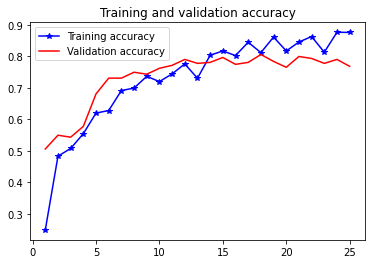

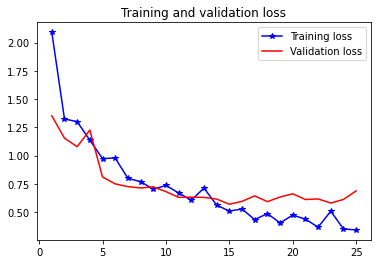

In [17]:
# Accuracy ve loss değerlerini alıyoruz
train_acc = history.history['acc'] 
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure() # Farklı bir grafik üzerinde gösteriyoruz

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss') # Eğitim doğruluğunu mavi renkte ve yıldız işaretleriyle çizdiriyoruz
plt.plot(epochs, val_loss, 'r', label = 'Validation loss') # Eğitim doğruluğunu kırmızı renkte çizdiriyoruz
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
pred_Y = model.predict(validation_generator, batch_size = 32, verbose = True)  # Test seti üzerinde tahmin yapılır
pred_Y_cat = np.argmax(pred_Y, -1) # Her tahminden en yüksek olasılığa sahip olan sınıfı seçiyoruz

11/11 [==============================] - 2s 176ms/step


14/14 [==============================] - 8s 601ms/step


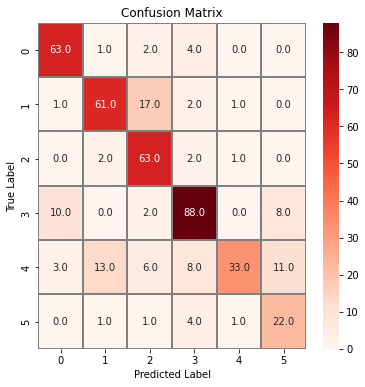

In [19]:
import numpy as np
import seaborn as sns # Isı haritasi şeklinde görselleştirmek için
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


pred_test = model.predict(test_generator, verbose=True)   # Test seti üzerinde tahmin yapılır
pred_test_cat = np.argmax(pred_test, axis=1)    # Her tahminden en yüksek olasılığa sahip olan sınıfı seçiyoruz

true_test_labels = test_generator.classes   # Gerçek etiketlerin dizisini döndürür tahminlere karşılık gelmesi için

confusion_mtx = confusion_matrix(true_test_labels, pred_test_cat)  # Gerçek etiketler ile tahmin edilen etiketler arasındaki ilişkiyi gösteren bir karışıklık matrisi

f, ax = plt.subplots(figsize=(6, 6)) # Grafiğin boyutlarını ayarlar
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Reds", linecolor="gray", fmt=".1f", ax=ax)   # Karışıklık matrisini ısı haritası (heatmap) şeklinde görselleştiriyoruz.

plt.xlabel("Predicted Label")  # X,Y eksenlerinin ve grafiğin adlandırılması
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [20]:
from sklearn.preprocessing import LabelBinarizer
LABELS=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"] # Etiket isimlerini belirliyoruz

labels = np.array(LABELS) # LABELS listesini bir NumPy dizisine dönüştürüyoruz
lb = LabelBinarizer() # LabelBinarizer sınıfından bir nesne oluşturuyoruz
labels = lb.fit_transform(labels) # Bu işlem sırasında her kategoriye bir sütun atanır.  Cardboard --> [1,0,0,0,0,0]

In [22]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=0bfa3d970729a789294c0d1cf72e4b6df3aafdf4ca990e998b3370cc08c3aa09
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


# **VGG19 Modelinin Test Edilmesi** 

In [23]:
# Test için gereken kütüphaneleri import ediyoruz

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [27]:
print("[INFO] loading object detector...") 
model = load_model('./VGG19_Garbage_Classifier.keras') # Eğittimiz modelin ağırlıklarını çağırdık
# bu ağırlığı modele verdik ve model bu ağırlığa göre test yapacak

[INFO] loading object detector...


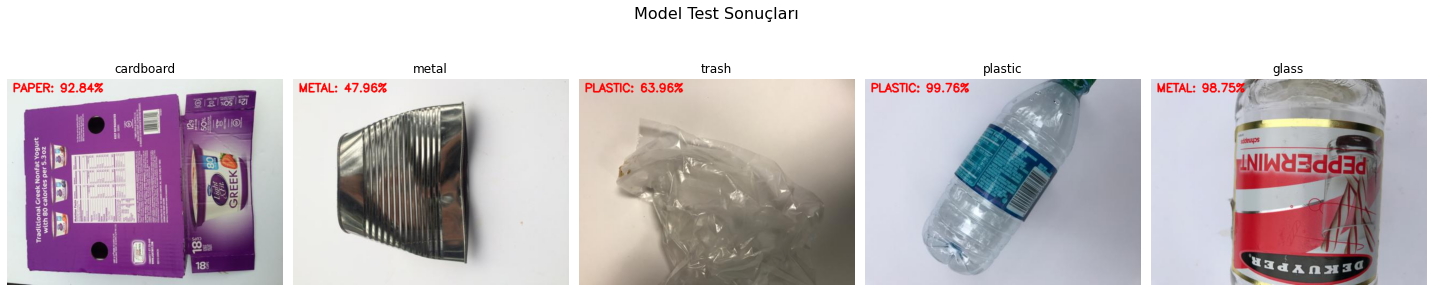

In [31]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Verilen predict fonksiyonu kullanılacak

def testRandom(test_dir, model, lb):
    classes = os.listdir(test_dir)  # Klasördeki sınıf isimlerini al
    selected_classes = random.sample(classes, 5)  # 5 rastgele sınıf seç

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Görselleri göstermek için bir figür oluştur
    fig.suptitle("Model Test Sonuçları", fontsize=16, y=0.95)  # Başlığı biraz yukarı taşı

    for i, cls in enumerate(selected_classes):
        class_dir = os.path.join(test_dir, cls)
        images = os.listdir(class_dir)  # Sınıfa ait görselleri al
        selected_image = random.choice(images)  # Rastgele bir görsel seç
        image_path = os.path.join(class_dir, selected_image)

        # Test ve görselleştirme
        try:
            result_image = predict(image_path, model, lb)
            axes[i].imshow(result_image)
            axes[i].set_title(cls, fontsize=12, color='black')  # Başlık rengi eklendi
            axes[i].axis('off')
        except Exception as e:
            print(f"Hata: {e}")

    plt.tight_layout()  # Elemanlar arası boşlukları optimize et
    plt.show()

def predict(imagePath, model, lb):
 
    image = cv2.imread(imagePath)
    if image is None:
        raise ValueError("Görsel yüklenemedi.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()

    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label_text = f"{label}: {proba[idx] * 100:.2f}%"

    cv2.putText(output, label_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    return output
path = '/kaggle/input/split-garbage-dataset/test'
# Kullanım örneği:
testRandom(path, model, lb)
